In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import math
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics as stats
import scipy
from scipy.stats.stats import pearsonr
from matplotlib import style
import warnings
import seaborn as sns
import requests
import bs4 as bs
import os
import csv
from openpyxl.workbook import Workbook as wb
from openpyxl import load_workbook
from openpyxl.styles import Font
from openpyxl.utils.dataframe import dataframe_to_rows
from pylab import rcParams
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
warnings.filterwarnings('ignore') 

In [2]:
#'2004-12-31', '2006-12-31', '2008-12-31', '2010-12-31', '2012-12-31', '2008-12-31'
#'2009-12-31', '2011-12-31', '2013-12-31', '2015-12-31', '2017-12-31', '2019-12-31'
#'2007-12-31', '2009-12-31', '2011-12-31', '2013-12-31', '2015-12-31', '2015-12-31'
#'2007-12-20', '2009-12-20', '2011-12-20', '2013-12-20', '2015-12-20', '2015-12-20'
#'2014-01-20', '2016-01-20', '2018-01-20', '2020-01-20'

In [3]:
start = input("Start Date ('1998-12-31'): ")
end = input("End Date ('2002-12-31'): ")
gamma_end = input("Gamma End Date ('2001-12-31'): ")
start_er =  input("Start Returns('2001-12-20'): ")
new_end = input("End for ROW: ")
year_excess_return = input("Years: ")

Start Date ('1998-12-31'): '2008-12-31'
End Date ('2002-12-31'): '2019-12-31'
Gamma End Date ('2001-12-31'): '2015-12-31'
Start Returns('2001-12-20'): '2015-12-20'
End for ROW: '2020-01-20'
Years: 3


In [4]:
data = pd.read_excel('stock_returns_data.xlsx')

In [5]:
df = data[['Names Date','Ticker Symbol','Returns']]

In [6]:
df = df[pd.to_numeric(df['Returns'], errors='coerce').notnull()]

In [7]:
df['Date'] = df['Names Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df

,Names Date,Ticker Symbol,Returns,Date
0,20070131,EWST,0.023279,2007-01-31
1,20070228,EWST,0.261621,2007-02-28
2,20070330,EWST,0.019732,2007-03-30
3,20070430,EWST,0.002764,2007-04-30
4,20070531,EWST,0.043418,2007-05-31
...,...,...,...,...
1048568,20191129,VT,0.025614,2019-11-29
1048569,20191231,VT,0.034494,2019-12-31
1048572,20080731,SZR,0.076445,2008-07-31
1048573,20080829,SZR,-0.040735,2008-08-29


In [8]:
df['Returns']=df['Returns']*100
df1 = df[['Date','Ticker Symbol','Returns']]
df1['Date'] = df1['Date'].map(lambda x: 100*x.year + x.month)
df1['Date'] = df1['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
df1

,Date,Ticker Symbol,Returns
0,2007-01-01,EWST,2.3279
1,2007-02-01,EWST,26.1621
2,2007-03-01,EWST,1.9732
3,2007-04-01,EWST,0.2764
4,2007-05-01,EWST,4.3418
...,...,...,...
1048568,2019-11-01,VT,2.5614
1048569,2019-12-01,VT,3.4494
1048572,2008-07-01,SZR,7.6445
1048573,2008-08-01,SZR,-4.0735


In [9]:
df1 = df1[(df1['Date'] > start) & (df1['Date'] < end)]
df1

,Date,Ticker Symbol,Returns
24,2009-01-01,EWST,3.414
25,2009-02-01,EWST,5.6222
26,2009-03-01,EWST,-8.0537
27,2009-04-01,EWST,4.4621
28,2009-05-01,EWST,0.2941
...,...,...,...
1048565,2019-08-01,VT,-2.1022
1048566,2019-09-01,VT,2.2762
1048567,2019-10-01,VT,2.7934
1048568,2019-11-01,VT,2.5614


In [10]:
df1 = df1.dropna(subset=['Ticker Symbol'])

In [11]:
fama = pd.read_excel('FF_Research_Data_Factors.xlsx')
fama = fama[['Date','Mkt-RF','RF']]
fama['Returns'] = fama['Mkt-RF']+fama['RF']
fama['Ticker Symbol']='SP500'
fama1 = fama[['Date','Ticker Symbol','Returns','RF']]
fama1['Date'] = fama1['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m'))
fama1

,Date,Ticker Symbol,Returns,RF
0,1926-07-01,SP500,3.18,0.22
1,1926-08-01,SP500,2.89,0.25
2,1926-09-01,SP500,0.59,0.23
3,1926-10-01,SP500,-2.92,0.32
4,1926-11-01,SP500,2.84,0.31
...,...,...,...,...
1120,2019-11-01,SP500,3.99,0.12
1121,2019-12-01,SP500,2.91,0.14
1122,2020-01-01,SP500,0.02,0.13
1123,2020-02-01,SP500,-8.01,0.12


In [12]:
dfAll = pd.concat([df1,fama1])
dfAll = dfAll.reset_index()
dfAll = dfAll[(dfAll['Date'] > start) & (dfAll['Date'] < end)]
dfAll = dfAll[['Date','Ticker Symbol','Returns','RF']]
#row1 = dfAll.tail(60)
row1 = dfAll.tail(132)
row1 = row1[(row1['Date'] > start) & (row1['Date'] < gamma_end)]
row1 = row1['RF'].values
#row2 = dfAll.tail(48)
row2 = dfAll.tail(48)
row2 = row2['RF'].values
#row3 = dfAll.tail(60)['RF'].values
row3 = dfAll.tail(132)['RF'].values


#row1
#row['RF'].iloc[-2]
#dfAll.tail(60)['RF'].iloc[-60,-36]

In [13]:
dfAll.tail(132)

,Date,Ticker Symbol,Returns,RF
857691,2009-01-01,SP500,-8.12,0.00
857692,2009-02-01,SP500,-10.09,0.01
857693,2009-03-01,SP500,8.97,0.02
857694,2009-04-01,SP500,10.2,0.01
857695,2009-05-01,SP500,5.21,0.00
...,...,...,...,...
857818,2019-08-01,SP500,-2.42,0.16
857819,2019-09-01,SP500,1.62,0.18
857820,2019-10-01,SP500,2.21,0.15
857821,2019-11-01,SP500,3.99,0.12


In [14]:
row2

array([0.01, 0.02, 0.02, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01,
       0.03, 0.04, 0.04, 0.03, 0.05, 0.06, 0.06, 0.07, 0.09, 0.09, 0.09,
       0.08, 0.09, 0.11, 0.11, 0.12, 0.14, 0.14, 0.14, 0.16, 0.16, 0.15,
       0.19, 0.18, 0.19, 0.21, 0.18, 0.19, 0.21, 0.21, 0.18, 0.19, 0.16,
       0.18, 0.15, 0.12, 0.14])

In [176]:
stock_count = dfAll.groupby('Ticker Symbol')['Returns'].count()
#stock_count = stock_count[stock_count == 60]
stock_count = stock_count[stock_count == 132]
stocks = [*stock_count.keys()]
#stocks

In [16]:
dfAll1 = dfAll.loc[dfAll['Ticker Symbol'].isin(stocks)]
dfAll1

,Date,Ticker Symbol,Returns,RF
248,2009-01-01,JJSF,-2.7035,NaN
249,2009-02-01,JJSF,-9.5675,NaN
250,2009-03-01,JJSF,10.1916,NaN
251,2009-04-01,JJSF,11.7325,NaN
252,2009-05-01,JJSF,-3.1992,NaN
...,...,...,...,...
857818,2019-08-01,SP500,-2.42,0.16
857819,2019-09-01,SP500,1.62,0.18
857820,2019-10-01,SP500,2.21,0.15
857821,2019-11-01,SP500,3.99,0.12


In [137]:
df_row = web.DataReader('VEMAX','yahoo',start,new_end)
df_row = df_row.reset_index()
df_row = df_row[['Date','Adj Close']]
df_row = df_row.resample('M', on='Date').last()
df_row = df_row[['Adj Close']]
df_row['Monthly Return'] = df_row['Adj Close'].pct_change()*100
df_row['ROW']=df_row['Monthly Return']
df_row = df_row[['ROW']]
df_row = df_row.reset_index()
df_row = df_row[(df_row['Date'] > start) & (df_row['Date'] < new_end)]
df_row = df_row.set_index('Date')
df_row

,ROW
Date,
2009-01-31,-8.218492
2009-02-28,-6.006689
2009-03-31,15.976344
2009-04-30,16.173471
2009-05-31,18.181818
...,...
2019-08-31,-3.782245
2019-09-30,1.333312
2019-10-31,3.867895


In [138]:
df_row['RiskFree']=row3
df_row['ExcessReturn']=df_row['ROW']-df_row['RiskFree']
row = df_row['ExcessReturn'].values
row

array([ -8.21849166,  -6.01668909,  15.95634405,  16.16347126,
        18.18181818,  -2.23966525,  11.58256019,  -0.65714213,
         9.28038662,  -1.31745453,   5.9122504 ,   3.64786564,
        -6.30867755,   1.09614943,   8.1684334 ,   0.24773682,
        -9.32162216,  -0.04150795,   9.22125785,  -2.20210082,
        11.16668263,   2.96078368,  -2.68901316,   7.28473009,
        -2.74459027,  -0.86116312,   5.60914629,   3.4482883 ,
        -2.78574863,  -1.5184962 ,  -0.7958167 ,  -8.58354808,
       -16.15029057,  13.50557602,  -3.39960541,  -3.2198315 ,
        11.08305444,   5.59972869,  -2.85325044,  -1.74564711,
       -11.06470628,   4.8192934 ,   0.66543167,   0.44072446,
         5.35776697,  -0.41243117,   1.288702  ,   5.8819276 ,
         0.62517112,  -1.75581823,  -1.54458343,   1.39816994,
        -3.72309858,  -6.13691612,   0.98978656,  -3.15467204,
         7.13672952,   4.67260801,  -1.99032587,  -0.95199601,
        -7.24380551,   3.42859435,   3.87680433,   0.53

In [139]:
###Beta calculations###
###Want monthly return beta from 2015 to 2017###
dfAll1.reset_index()
dfBeta = dfAll1[(dfAll1['Date'] > start) & (dfAll1['Date'] < gamma_end)]
dfBeta = dfBeta.reset_index()
dfBeta = dfBeta[['Date','Ticker Symbol','Returns','RF']]
dfBeta

,Date,Ticker Symbol,Returns,RF
0,2009-01-01,JJSF,-2.7035,NaN
1,2009-02-01,JJSF,-9.5675,NaN
2,2009-03-01,JJSF,10.1916,NaN
3,2009-04-01,JJSF,11.7325,NaN
4,2009-05-01,JJSF,-3.1992,NaN
...,...,...,...,...
248215,2015-08-01,SP500,-6.04,0.00
248216,2015-09-01,SP500,-3.08,0.00
248217,2015-10-01,SP500,7.75,0.00
248218,2015-11-01,SP500,0.56,0.00


In [140]:
#panel data
symbols = dfBeta.groupby('Ticker Symbol')
market_df = symbols.get_group('SP500')
market_df = market_df[['Date','Returns']].set_index('Date')
table = dfBeta.pivot(index='Date',columns='Ticker Symbol',values='Returns')  
table

Ticker Symbol,A,AAME,AAON,AAP,AAPL,AAU,AAWW,AB,ABB,ABC,...,YRCW,YUM,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZN,ZTR,ZUMZ
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,15.675,29.3801,-13.2184,-2.734,5.6005,20,-23.2275,-16.4502,-13.058,1.8508,...,0.3484,-8.5397,-16.9299,-22.0913,-39.1269,45.6897,9.2437,22.8024,-1.0979,-4.0268
2009-02-01,-23.2854,-29.6875,-14.3488,16.8653,-0.9098,-6.4103,-2.55,-28.7471,-7.6628,-12.2797,...,-23.6111,-8.1761,4.3969,-21.6761,-36.9303,-7.6923,-24.6154,83.8143,-6.9091,10.3496
2009-03-01,10.8147,6.6667,16.7526,7.5556,17.7024,2.7397,22.7016,20.9532,15.6846,2.8338,...,104.091,4.5662,8.2527,22.5363,4.9093,-19.2436,4.0816,-19.4539,4.2763,22.9404
2009-04-01,18.8029,-7.6389,7.5055,6.4995,19.7013,-14.6667,53.0259,19.4973,2.0086,3.0006,...,-32.5167,22.0524,11.7245,20.8965,11.1902,4.7944,18.6275,-12.9661,6.1146,24.3299
2009-05-01,-0.1643,26.3158,6.7762,-2.6514,7.9313,42.1719,-2.5235,8.9041,15.7525,10.5826,...,-14.8515,3.8381,2.7294,0.4362,25.5261,145.417,37.1901,-14.5083,2.7879,-26.0365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,-11.3309,-3.2258,-6.8049,0.597,-6.6117,-13.3087,-15.9512,1.2741,-4.783,-5.1253,...,-13.4197,-9.1044,-22.9954,7.0132,-6.8291,-34.8054,-10.2459,-15.3409,-5.7659,-10.6897
2015-09-01,-5.1776,12.2222,-6.2863,8.1826,-2.1816,6.6296,-16.3399,-2.7067,-8.493,-5.048,...,-20.6463,0.2256,-7.6375,-23.166,-5.0345,3.4443,-3.8813,-4.0268,-3.4341,-32.9472
2015-10-01,9.9913,9.1584,5.6244,4.6958,8.3409,-2.744,19.3287,-1.6165,6.8478,1.6002,...,37.7074,-10.7317,0.4572,-3.8191,4.4662,26.4151,23.0404,39.8601,6.4781,11.8362


In [141]:
table['RiskFree'] = row1
#table['ROW'] = row[:36]
table['ROW'] = row[:84]
table1 = table.reset_index()
table1

Ticker Symbol,Date,A,AAME,AAON,AAP,AAPL,AAU,AAWW,AB,ABB,...,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZN,ZTR,ZUMZ,RiskFree,ROW
0,2009-01-01,15.675,29.3801,-13.2184,-2.734,5.6005,20,-23.2275,-16.4502,-13.058,...,-16.9299,-22.0913,-39.1269,45.6897,9.2437,22.8024,-1.0979,-4.0268,0.00,-8.218492
1,2009-02-01,-23.2854,-29.6875,-14.3488,16.8653,-0.9098,-6.4103,-2.55,-28.7471,-7.6628,...,4.3969,-21.6761,-36.9303,-7.6923,-24.6154,83.8143,-6.9091,10.3496,0.01,-6.016689
2,2009-03-01,10.8147,6.6667,16.7526,7.5556,17.7024,2.7397,22.7016,20.9532,15.6846,...,8.2527,22.5363,4.9093,-19.2436,4.0816,-19.4539,4.2763,22.9404,0.02,15.956344
3,2009-04-01,18.8029,-7.6389,7.5055,6.4995,19.7013,-14.6667,53.0259,19.4973,2.0086,...,11.7245,20.8965,11.1902,4.7944,18.6275,-12.9661,6.1146,24.3299,0.01,16.163471
4,2009-05-01,-0.1643,26.3158,6.7762,-2.6514,7.9313,42.1719,-2.5235,8.9041,15.7525,...,2.7294,0.4362,25.5261,145.417,37.1901,-14.5083,2.7879,-26.0365,0.00,18.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2015-08-01,-11.3309,-3.2258,-6.8049,0.597,-6.6117,-13.3087,-15.9512,1.2741,-4.783,...,-22.9954,7.0132,-6.8291,-34.8054,-10.2459,-15.3409,-5.7659,-10.6897,0.00,-9.327882
80,2015-09-01,-5.1776,12.2222,-6.2863,8.1826,-2.1816,6.6296,-16.3399,-2.7067,-8.493,...,-7.6375,-23.166,-5.0345,3.4443,-3.8813,-4.0268,-3.4341,-32.9472,0.00,-3.269292
81,2015-10-01,9.9913,9.1584,5.6244,4.6958,8.3409,-2.744,19.3287,-1.6165,6.8478,...,0.4572,-3.8191,4.4662,26.4151,23.0404,39.8601,6.4781,11.8362,0.00,5.589839
82,2015-11-01,10.7521,8.39,21.2506,-17.9912,-0.569,-7.1429,0.194,-4.8174,-0.3178,...,4.2913,17.8683,4.3448,14.8376,8.3012,-2,1.7482,-13.6728,0.00,-3.231343


In [142]:
s = table1.columns[1:]
s

Index(['A', 'AAME', 'AAON', 'AAP', 'AAPL', 'AAU', 'AAWW', 'AB', 'ABB', 'ABC',
       ...
       'ZBRA', 'ZEUS', 'ZION', 'ZIOP', 'ZIXI', 'ZN', 'ZTR', 'ZUMZ', 'RiskFree',
       'ROW'],
      dtype='object', name='Ticker Symbol', length=2957)

In [143]:
beta_df = []
for stock in s:
    table1[stock] = table1[stock]-table1['RiskFree']
    beta_df.append({'Date':table1['Date'], 'Ticker':stock, 'ExcessReturn': table1[stock]})
beta_df = pd.DataFrame(beta_df)
beta_df1 = beta_df.set_index(['Ticker']).apply(pd.Series.explode).reset_index()

In [144]:
beta_df2 = beta_df1.pivot(index='Date',columns='Ticker',values='ExcessReturn')
beta_df2
#beta_df2['ROW'] = row
#beta_df2['ROW']

Ticker,A,AAME,AAON,AAP,AAPL,AAU,AAWW,AB,ABB,ABC,...,YRCW,YUM,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZN,ZTR,ZUMZ
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,15.675,29.3801,-13.2184,-2.734,5.6005,20,-23.2275,-16.4502,-13.058,1.8508,...,0.3484,-8.5397,-16.9299,-22.0913,-39.1269,45.6897,9.2437,22.8024,-1.0979,-4.0268
2009-02-01,-23.2954,-29.6975,-14.3588,16.8553,-0.9198,-6.4203,-2.56,-28.7571,-7.6728,-12.2897,...,-23.6211,-8.1861,4.3869,-21.6861,-36.9403,-7.7023,-24.6254,83.8043,-6.9191,10.3396
2009-03-01,10.7947,6.6467,16.7326,7.5356,17.6824,2.7197,22.6816,20.9332,15.6646,2.8138,...,104.071,4.5462,8.2327,22.5163,4.8893,-19.2636,4.0616,-19.4739,4.2563,22.9204
2009-04-01,18.7929,-7.6489,7.4955,6.4895,19.6913,-14.6767,53.0159,19.4873,1.9986,2.9906,...,-32.5267,22.0424,11.7145,20.8865,11.1802,4.7844,18.6175,-12.9761,6.1046,24.3199
2009-05-01,-0.1643,26.3158,6.7762,-2.6514,7.9313,42.1719,-2.5235,8.9041,15.7525,10.5826,...,-14.8515,3.8381,2.7294,0.4362,25.5261,145.417,37.1901,-14.5083,2.7879,-26.0365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,-11.3309,-3.2258,-6.8049,0.597,-6.6117,-13.3087,-15.9512,1.2741,-4.783,-5.1253,...,-13.4197,-9.1044,-22.9954,7.0132,-6.8291,-34.8054,-10.2459,-15.3409,-5.7659,-10.6897
2015-09-01,-5.1776,12.2222,-6.2863,8.1826,-2.1816,6.6296,-16.3399,-2.7067,-8.493,-5.048,...,-20.6463,0.2256,-7.6375,-23.166,-5.0345,3.4443,-3.8813,-4.0268,-3.4341,-32.9472
2015-10-01,9.9913,9.1584,5.6244,4.6958,8.3409,-2.744,19.3287,-1.6165,6.8478,1.6002,...,37.7074,-10.7317,0.4572,-3.8191,4.4662,26.4151,23.0404,39.8601,6.4781,11.8362


In [145]:
y = beta_df2[['A']].values
x = beta_df2[['SP500', 'ROW']] 
regr = linear_model.LinearRegression()
regr.fit(x, y)
model = sm.OLS(y.astype(float), x.astype(float)).fit()
beta = model.params
beta

SP500    1.520886
ROW     -0.027649
dtype: float64

In [146]:
equities = beta_df2.columns
main_df = []
for equity in equities:
    y = beta_df2[[equity]].values
    x = beta_df2[['SP500', 'ROW']] 
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    model = sm.OLS(y.astype(float), x.astype(float)).fit()
    predictions = model.predict(x) 
    beta = regr.coef_
    main_df.append({'Ticker':equity, 'Beta': beta})
main_df = pd.DataFrame(main_df)
main_df

,Ticker,Beta
0,A,"[[1.5069020273752578, -0.022227301139500024]]"
1,AAME,"[[0.2789179484462171, 0.2892196389249203]]"
2,AAON,"[[1.527642874141959, -0.2739451605502728]]"
3,AAP,"[[0.3614986240670996, 0.0558328400592996]]"
4,AAPL,"[[0.5211519435040627, 0.34331416594549125]]"
...,...,...
2952,ZIOP,"[[-0.1943411056172558, 1.5699624381487896]]"
2953,ZIXI,"[[0.5990515589406731, 0.43151130671771887]]"
2954,ZN,"[[0.05849221848304275, 0.18114556412327482]]"
2955,ZTR,"[[0.4539631372868063, 0.06846091357944295]]"


In [147]:
equities = beta_df2.columns
main_df = []
for equity in equities:    
    y = beta_df2[[equity]].values
    x = beta_df2[['SP500', 'ROW']]
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    model = sm.OLS(y.astype(float), x.astype(float)).fit()
    beta = model.params 
    main_df.append({'Ticker':equity, 'Beta': beta[0], 'Gamma': beta[1]})
main_df = pd.DataFrame(main_df)
#main_df.to_excel('gamma_tickers.xlsx')

In [148]:
main_df1 = main_df.set_index('Ticker')
#main_df1.to_excel('beta_regression.xlsx')

In [149]:
#x = main_df1.index
#drop = x[3433]
#x = x.drop(drop)
#x
row1

array([0.  , 0.01, 0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01])

In [150]:
df_stock_returns = dfAll1[(dfAll1['Date'] > start_er) & (dfAll1['Date'] < end)]
stock_annual_returns = df_stock_returns.loc[df_stock_returns['Ticker Symbol'].isin(stocks)]
stock_returns = stock_annual_returns.pivot(index='Date',columns='Ticker Symbol',values='Returns')
stock_returns['Risk Free Rate'] = row2
stock_returns = stock_returns.reset_index()
z = stock_returns.columns
z = z[1:]
stock_returns_previous = []
for item in z:
    stock_returns[item] = stock_returns[item]-stock_returns['Risk Free Rate']
    stock_returns_previous.append({'Ticker':item, 'Excess Return': stock_returns[item].sum()})
stock_returns_previous = pd.DataFrame(stock_returns_previous)
stock_returns_previous
#stock_returns_previous.iloc[2500]

,Ticker,Excess Return
0,A,79.9979
1,AAME,-75.4297
2,AAON,85.7938
3,AAP,19.5611
4,AAPL,120.3322
...,...,...
2951,ZIXI,50.2320
2952,ZN,-61.5822
2953,ZTR,43.6453
2954,ZUMZ,131.8108


In [151]:
#divide this by three years 
stock_returns_previous['Annual Excess Return'] = stock_returns_previous['Excess Return']/int(year_excess_return)
excess_return_df = stock_returns_previous[['Ticker', 'Annual Excess Return']].set_index('Ticker')
#excess_return_df.index[3495]
#excess_return_df.to_excel('ExcessReturnRegression.xlsx')

In [152]:
main1 = pd.concat([main_df1,excess_return_df],axis=1)
main1.index.names = ['Ticker']
main = main1
main = main.reset_index()
main.to_excel('gamma_tickers.xlsx')

In [153]:
###Go to mrkt cap weight portfolio to finish the weights to transport to excel

In [154]:
###Go to mrkt cap weight portfolio to finish the weights to transport to excel

In [155]:
###Go to mrkt cap weight portfolio to finish the weights to transport to excel

In [156]:
weights = pd.read_excel('weights.xlsx')

In [157]:
weights

,Ticker,Market Cap,Weight
0,AAON,1.189199e+06,0.000308
1,AAPL,5.426098e+08,0.140569
2,AAU,5.280540e+04,0.000014
3,AB,1.549624e+06,0.000401
4,ABB,1.650813e+06,0.000428
...,...,...,...
353,ZION,5.119896e+06,0.001326
354,ZIXI,2.872588e+05,0.000074
355,ZN,7.108920e+04,0.000018
356,ZTR,2.168745e+05,0.000056


In [158]:
weights = weights.set_index('Ticker')
weights.index.names = ['Ticker']
weights

,Market Cap,Weight
Ticker,,
AAON,1.189199e+06,0.000308
AAPL,5.426098e+08,0.140569
AAU,5.280540e+04,0.000014
AB,1.549624e+06,0.000401
ABB,1.650813e+06,0.000428
...,...,...
ZION,5.119896e+06,0.001326
ZIXI,2.872588e+05,0.000074
ZN,7.108920e+04,0.000018


In [159]:
whole = pd.concat([main1,weights],axis=1)
whole = whole.dropna()
whole['Beta Weighted'] = whole['Beta']*whole['Weight']
whole['Gamma Weighted'] = whole['Gamma']*whole['Weight']
whole['Excess Return Weighted'] = whole['Annual Excess Return']*whole['Weight']
whole_gamma = whole.sort_values('Gamma',ascending = False)
whole_beta = whole.sort_values('Beta',ascending = False)
whole_weight = whole.sort_values('Weight',ascending = False)
whole_gamma_weight = whole.sort_values('Gamma Weighted',ascending = False)
whole_beta_weight = whole.sort_values('Beta Weighted',ascending = False)
whole_excess_return_weight = whole.sort_values('Excess Return Weighted',ascending = False)
whole_excess_return_weight

,Beta,Gamma,Annual Excess Return,Market Cap,Weight,Beta Weighted,Gamma Weighted,Excess Return Weighted
AAPL,0.745360,0.256389,40.110733,5.426098e+08,0.140569,0.104775,0.036040,5.638334
AMZN,0.760787,0.059033,36.986767,3.183442e+08,0.082471,0.062743,0.004869,3.050323
WMT,0.479917,-0.123765,25.718267,1.755346e+08,0.045474,0.021824,-0.005628,1.169518
V,0.849804,-0.103819,30.399000,1.452619e+08,0.037632,0.031980,-0.003907,1.143967
UNH,1.020454,-0.201470,33.840800,1.048857e+08,0.027172,0.027728,-0.005474,0.919517
...,...,...,...,...,...,...,...,...
UTHR,1.065794,-0.009088,-14.288200,7.166630e+06,0.001857,0.001979,-0.000017,-0.026527
TWMC,0.903474,-0.207303,-99.911133,2.230555e+06,0.000578,0.000522,-0.000120,-0.057734
AKRX,1.213268,-0.326171,-57.166767,4.455822e+06,0.001154,0.001401,-0.000377,-0.065989
TNK,1.478923,0.081281,-7.849700,5.080600e+07,0.013162,0.019465,0.001070,-0.103317


In [160]:
size = whole.sort_values('Market Cap',ascending = False)
size

,Beta,Gamma,Annual Excess Return,Market Cap,Weight,Beta Weighted,Gamma Weighted,Excess Return Weighted
AAPL,0.745360,0.256389,40.110733,5.426098e+08,0.140569,1.047746e-01,3.604039e-02,5.638334
AMZN,0.760787,0.059033,36.986767,3.183442e+08,0.082471,6.274258e-02,4.868524e-03,3.050323
XOM,0.793479,-0.123904,2.164133,2.675668e+08,0.069316,5.500092e-02,-8.588587e-03,0.150010
WFC,1.526174,0.039755,5.481100,2.369658e+08,0.061389,9.368982e-02,2.440522e-03,0.336477
WMT,0.479917,-0.123765,25.718267,1.755346e+08,0.045474,2.182383e-02,-5.628124e-03,1.169518
...,...,...,...,...,...,...,...,...
ARTW,-0.074066,1.009845,-12.993100,1.258910e+04,0.000003,-2.415560e-07,3.293457e-06,-0.000042
UUU,0.066479,0.593840,-54.132067,1.036224e+04,0.000003,1.784596e-07,1.594136e-06,-0.000145
AMS,0.794877,-0.041742,18.849233,9.869760e+03,0.000003,2.032400e-06,-1.067289e-07,0.000048
CLWT,0.780789,0.823442,40.325400,4.821519e+03,0.000001,9.752588e-07,1.028535e-06,0.000050


In [166]:
s = size[238:][['Beta','Gamma','Annual Excess Return']].sort_values('Gamma',ascending = False)
m = size[119:238][['Beta','Gamma','Annual Excess Return']].sort_values('Gamma',ascending = False)
l = size[:119][['Beta','Gamma','Annual Excess Return']].sort_values('Gamma',ascending = False)

In [167]:
l

,Beta,Gamma,Annual Excess Return
WLL,0.287074,1.582101,1.942000
AEM,-1.127287,1.026540,37.386267
APA,0.305529,0.870544,-3.437767
USO,0.016684,0.733083,8.987367
WLK,1.368003,0.713164,15.106433
...,...,...,...
TOL,1.760746,-0.426727,8.353133
WAL,2.121486,-0.464719,19.999900
ALNY,2.308207,-0.680613,28.501200
VRTX,1.557938,-0.843906,24.313533


In [168]:
###gamma of each portfolio sorted by size (mkt-cap)
group_size = 23
portfolios = [s.iloc[i:i+group_size] for i in range(0,len(s)-group_size+1,group_size)]   
small_portfolio_gammas = []
for portfolio in portfolios:
    g = (portfolio['Gamma'].mean())
    b = (portfolio['Beta'].mean())
    r = (portfolio['Annual Excess Return'].mean())
    small_portfolio_gammas.append({'Gamma':g, 'Beta':b, 'Annual Excess Return':r})
small_portfolio_gammas = pd.DataFrame(small_portfolio_gammas)
small_portfolio_gammas

,Gamma,Beta,Annual Excess Return
0,1.037979,0.193073,15.152417
1,0.452313,0.638756,8.434593
2,0.195960,0.516643,13.371716
3,0.023263,0.683877,22.720630
4,-0.237641,1.148088,28.020794


In [169]:
###gamma of each portfolio sorted by size (mkt-cap)
group_size = 23
portfolios = [m.iloc[i:i+group_size] for i in range(0,len(m)-group_size+1,group_size)]   
medium_portfolio_gammas = []
for portfolio in portfolios:
    g = (portfolio['Gamma'].mean())
    b = (portfolio['Beta'].mean())
    r = (portfolio['Annual Excess Return'].mean())
    medium_portfolio_gammas.append({'Gamma':g, 'Beta':b, 'Annual Excess Return':r})
medium_portfolio_gammas = pd.DataFrame(medium_portfolio_gammas)
medium_portfolio_gammas

,Gamma,Beta,Annual Excess Return
0,0.550182,0.757658,10.809616
1,0.273246,0.853238,10.944933
2,0.068147,1.094563,10.594113
3,-0.095280,1.109565,12.128154
4,-0.319785,1.487152,10.177084


In [170]:
###gamma of each portfolio sorted by size (mkt-cap)
group_size = 23
portfolios = [l.iloc[i:i+group_size] for i in range(0,len(l)-group_size+1,group_size)]   
large_portfolio_gammas = []
for portfolio in portfolios:
    g = (portfolio['Gamma'].mean())
    b = (portfolio['Beta'].mean())
    r = (portfolio['Annual Excess Return'].mean())
    large_portfolio_gammas.append({'Gamma':g, 'Beta':b, 'Annual Excess Return':r})
large_portfolio_gammas = pd.DataFrame(large_portfolio_gammas)
large_portfolio_gammas

,Gamma,Beta,Annual Excess Return
0,0.587080,0.647640,13.625010
1,0.181497,0.946895,15.162910
2,0.020427,1.135483,17.298558
3,-0.077145,1.125395,17.206577
4,-0.251203,1.254934,16.779226


In [171]:
###gamma of each portfolio sorted from highest to lowest beta
group_size = 35
portfolios = [whole_gamma_weight.iloc[i:i+group_size] for i in range(0,len(whole_gamma_weight)-group_size+1,group_size)]   
portfolio_gammas = []
for portfolio in portfolios:
    g = (portfolio['Gamma Weighted'].sum())
    b = (portfolio['Beta Weighted'].sum())
    r = (portfolio['Excess Return Weighted'].sum())
    portfolio_gammas.append({'Gamma Weighted':g, 'Beta Weighted':b, 'Excess Return Weighted':r})
portfolio_gammas = pd.DataFrame(portfolio_gammas)
portfolio_gammas

,Gamma Weighted,Beta Weighted,Excess Return Weighted
0,0.093287,0.365657,11.052467
1,0.008905,0.055144,0.696508
2,0.002971,0.031809,0.485686
3,0.001199,0.011540,0.196927
4,0.000485,0.025420,0.599260
5,0.000132,0.004724,0.042984
6,-0.000122,0.003304,0.053252
7,-0.001156,0.031125,0.460237
8,-0.004120,0.043567,0.565236
9,-0.023928,0.202578,2.719064


In [172]:
###2008-2012
whole_beta_weight
###gamma of each portfolio sorted from highest to lowest beta
group_size = 35
portfolios = [whole_beta_weight.iloc[i:i+group_size] for i in range(0,len(whole_beta_weight)-group_size+1,group_size)]   
portfolio_betas = []
for portfolio in portfolios:
    g = (portfolio['Gamma Weighted'].sum())
    b = (portfolio['Beta Weighted'].sum())
    r = (portfolio['Excess Return Weighted'].sum())
    portfolio_betas.append({'Gamma Weighted':g, 'Beta Weighted':b, 'Excess Return Weighted':r})
portfolio_betas = pd.DataFrame(portfolio_betas)
portfolio_betas

,Gamma Weighted,Beta Weighted,Excess Return Weighted
0,0.001329,0.746255,17.102431
1,0.005642,0.103558,1.759406
2,0.006376,0.058719,0.634199
3,0.007043,0.032465,0.944573
4,0.004184,0.018947,0.244237
5,0.002464,0.009967,0.116765
6,0.005425,0.004265,0.105414
7,0.001034,0.001631,0.023953
8,0.000487,0.000402,0.023576
9,0.000208,-0.000102,0.008485


In [173]:
###SP500 excess return for this period
#excess_return_df.iloc[3495]
excess_return_df.iloc[2488]

Annual Excess Return    17.49
Name: SP500, dtype: float64

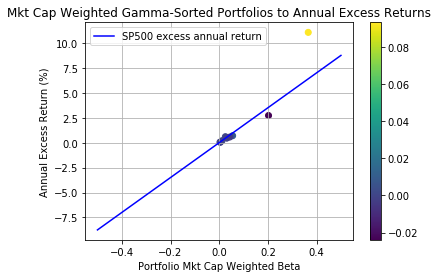

In [174]:
###2009-2019
plt.scatter(x = portfolio_gammas['Beta Weighted'], y=portfolio_gammas['Excess Return Weighted'], c=portfolio_gammas['Gamma Weighted'])
#plt.scatter(x = portfolio_betas['Beta Weighted'], y=portfolio_betas['Excess Return Weighted'], c='r')
plt.title('Mkt Cap Weighted Gamma-Sorted Portfolios to Annual Excess Returns')
plt.xlabel('Portfolio Mkt Cap Weighted Beta')
plt.ylabel('Annual Excess Return (%)')
x = np.linspace(-.5,.5,2)
#x = np.linspace(-10,10,20)
y = 17.49*x
plt.plot(x, y, '-b', label='SP500 excess annual return')
plt.legend(loc='upper left')
plt.grid()
plt.colorbar()
plt.show()

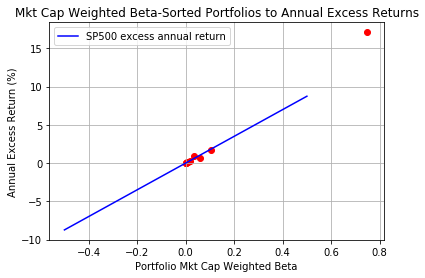

In [175]:
#plt.scatter(x = portfolio_gammas['Beta Weighted'], y=portfolio_gammas['Excess Return Weighted'], c=portfolio_gammas['Gamma Weighted'])
plt.scatter(x = portfolio_betas['Beta Weighted'], y=portfolio_betas['Excess Return Weighted'], c='r')
plt.title('Mkt Cap Weighted Beta-Sorted Portfolios to Annual Excess Returns')
plt.xlabel('Portfolio Mkt Cap Weighted Beta')
plt.ylabel('Annual Excess Return (%)')
x = np.linspace(-.5,.5,2)
#x = np.linspace(-10,10,20)
y = 17.49*x
plt.plot(x, y, '-b', label='SP500 excess annual return')
plt.legend(loc='upper left')
plt.grid()
#plt.colorbar()
plt.show()